## Random Forests

Random Forests are a powerful and popular supervised machine learning algorithm. They are an ensemble method, meaning they work by combining the predictions from multiple individual models to make a more accurate and robust final prediction. Specifically, a Random Forest is an ensemble of many individual Decision Trees.

The algorithm works by building a large number of Decision Trees on various random subsets of the data and features. To make a final prediction, it then aggregates the results from all the trees:
- For classification, it takes a majority vote (the most common prediction among all trees).
- For regression, it takes the average of all the predictions.

This process of averaging helps to correct for the main weakness of a single Decision Tree: its tendency to overfit to the training data.

<img src="randforest1.png" width="700"/>

Because of their high accuracy and resistance to overfitting, Random Forests are one of the most widely used algorithms for a variety of tasks, from finance to healthcare.

In this project, we will explore both applications of this algorithm using our `all_seasons.csv` dataset. First, we will train a model to predict whether a player is a "High-Usage" player (a classification task). Then, we will see how the algorithm performs on a regression task by training a model to predict a player's assists per game.

We will use the following libraries:

1. matplotlib (https://matplotlib.org/)
2. numpy (https://numpy.org/)
3. pandas (https://pandas.pydata.org/)
4. seaborn (https://seaborn.pydata.org/)
5. scikit learn (https://scikit-learn.org/)

Start by importing them, then loading our dataset.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

df = pd.read_csv('all_seasons.csv')

Format and clean up the dataset first, to prevent errors in case of missing entries:

In [51]:
df.columns = [col.strip().lower() for col in df.columns]
df = df.drop(columns=['unnamed: 0'], errors='ignore')
df = df.dropna(subset=['pts', 'ast', 'reb', 'net_rating', 'usg_pct']).copy()

### Part 1: Usage Rate

We define a "high usage" player as one with a usage rate in the 75th percentile and higher.

In [52]:
usage_threshold = df['usg_pct'].quantile(0.75)
df['high_usage'] = (df['usg_pct'] >= usage_threshold).astype(int)
df = df.fillna(0)

Now we will define our variables.

In [53]:
features_cls = ['age', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'ts_pct']
X_cls = df[features_cls]
y_cls = df['high_usage']
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

Now we will train the classifier model.

In [54]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train_cls, y_train_cls)

y_pred_cls = rf_classifier.predict(X_test_cls)

print(f"\nRandom Forest Classifier Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.4f}\n")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))


Random Forest Classifier Accuracy: 0.8603

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1922
           1       0.91      0.49      0.64       647

    accuracy                           0.86      2569
   macro avg       0.88      0.74      0.78      2569
weighted avg       0.87      0.86      0.84      2569




Confusion Matrix:


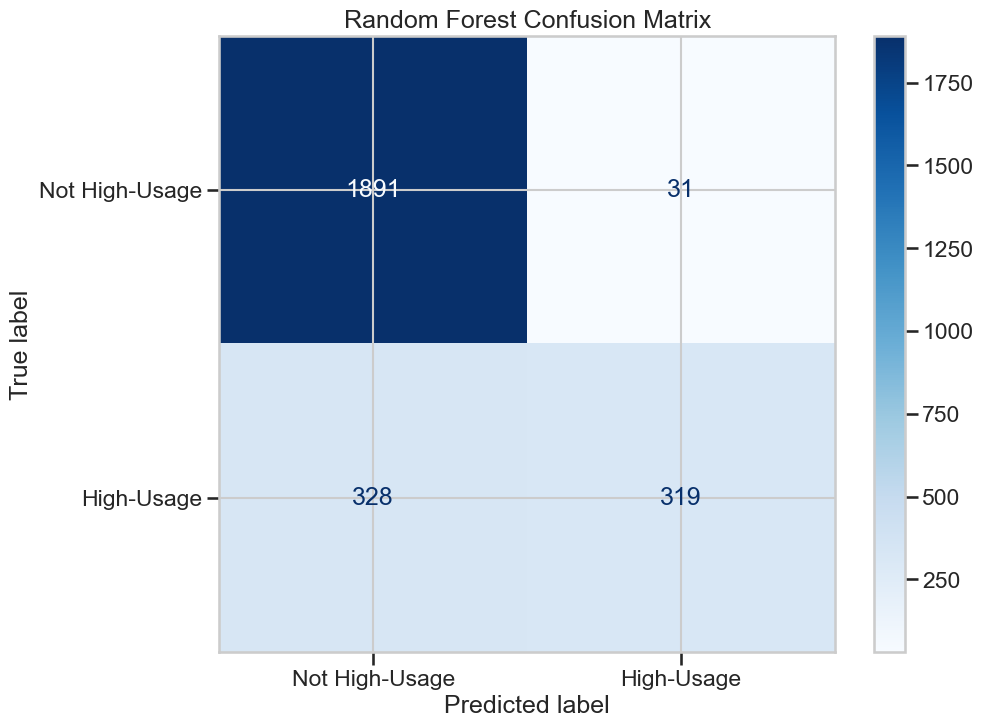

In [55]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High-Usage', 'High-Usage'])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

What features and stats were most important to predictions:

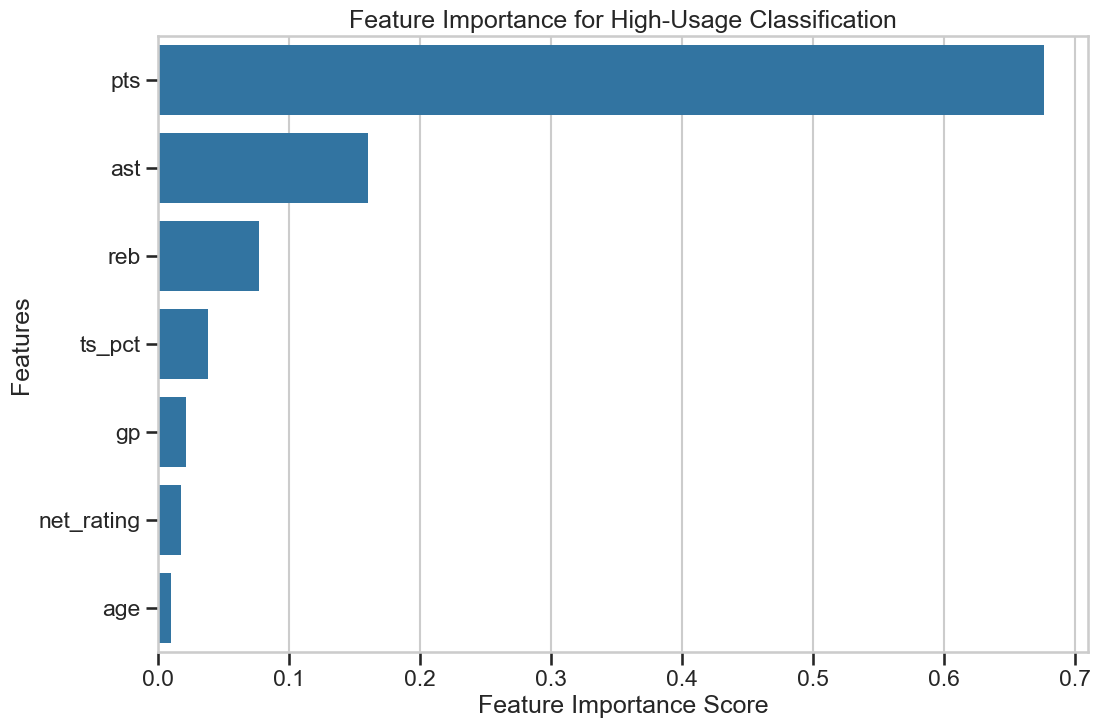

In [56]:
importances_cls = rf_classifier.feature_importances_
feature_imp_cls = pd.Series(importances_cls, index=features_cls).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_imp_cls, y=feature_imp_cls.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance for High-Usage Classification")
plt.show()

Analyzing our results, our model is pretty accurate in predicting usage rate.  It had more false positives than false negatives, which when combined with our findings taht points per game was the most important feature for predictions, suggests there were more players who scored a high number of points in a short amount of time than players who scored an exceedingly low amount of points in a long period of time. Essentially, that there were more players who were prolific scorers in a short amount of time compared to players who were possibly more defensive oriented and scored less points in a longer amount of time. This points to the overall shift in overall more offensive minded players in an increasingly offensive minded league that we have seen in the past few years, illustrated in our model through false positives.

### Part 2: Assists Predictor

Define variables:

In [57]:
features_reg = ['age', 'gp', 'pts', 'reb', 'net_rating', 'usg_pct', 'ts_pct']
X_reg = df[features_reg]
y_reg = df['ast']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Then run the model:

In [58]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

y_pred_reg = rf_regressor.predict(X_test_reg)

print(f"\nR-squared (R2): {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.4f}")


R-squared (R2): 0.5199
Mean Absolute Error (MAE): 0.8222
Mean Squared Error (MSE): 1.5137


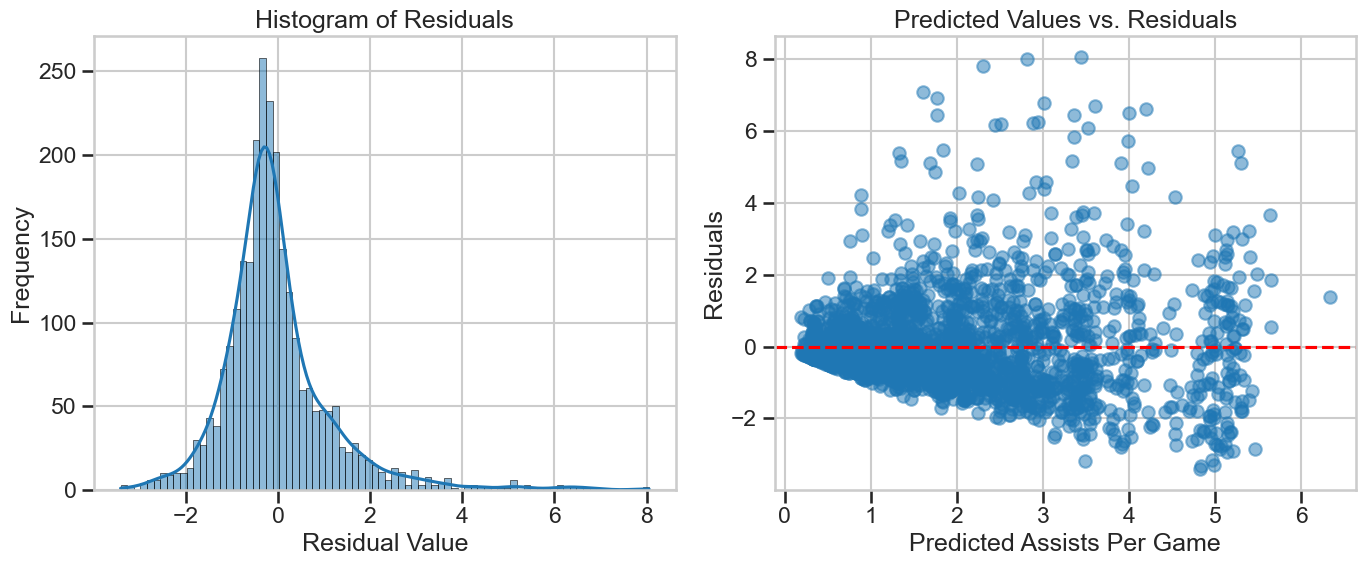

In [59]:
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.scatter(y_pred_reg, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Predicted Values vs. Residuals')
plt.xlabel('Predicted Assists Per Game')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

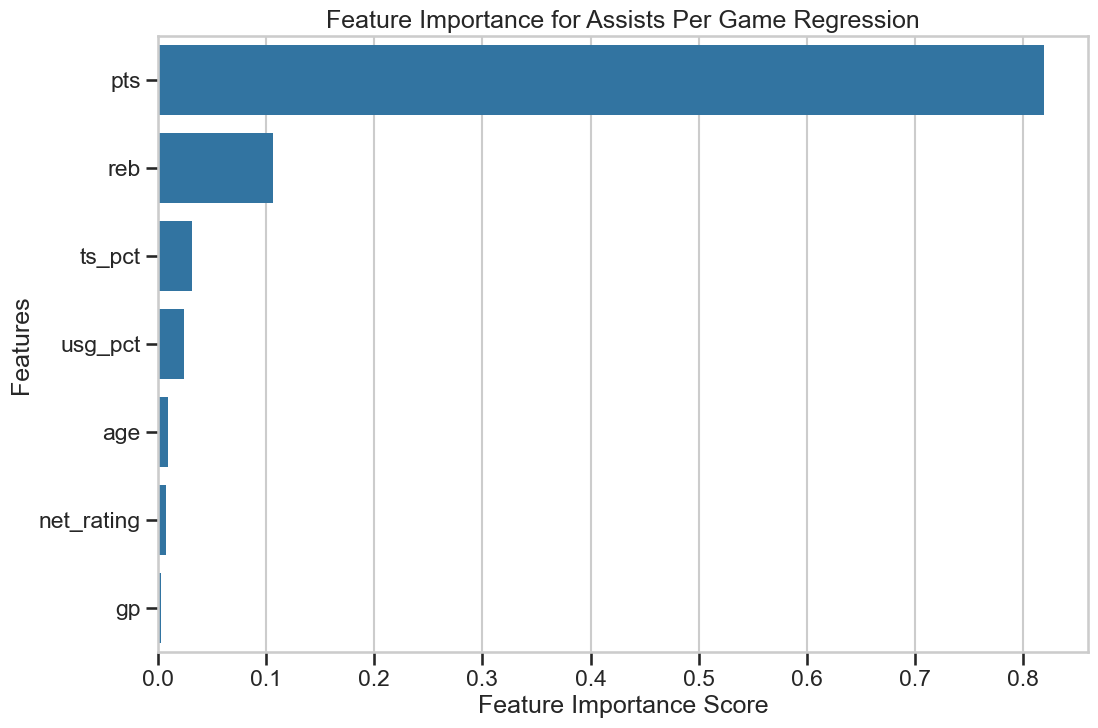

In [60]:
importances_reg = rf_regressor.feature_importances_
feature_imp_reg = pd.Series(importances_reg, index=features_reg).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_imp_reg, y=feature_imp_reg.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance for Assists Per Game Regression")
plt.show()

What we see from these results is that while there was not an excess amount of error when running predictions, the model was not as accurate as it could have been overall. This makes sense, as assists don't intuitively relate to any specific statistic, aside from maybe usage rate or play time. This brings up something even more peculiar, that being the low ranking in the importance of usage rate in our predictions. This could further suggest the isolation of assists and passing as a skill, and could even point towards assists and ball movement being more team-oriented as a statistic versus being an individually oriented stat.